# GY521

 GY521 is installed on RaspberryPi 
 
        

## A first test on GY521

<ul>
    <li> <a href="gy521Emitterpy">gy521Emitter.py</a>: reads GY521 and emits (via MQTT) the event:
        
<tt>msg(g521,event,rasp,none,g521(TYPE,X,Y,Z),N)</tt>
        
The events can be plotted by using <a href="mqttPlotQakEventspy">mqttPlotQakEvents.py</a>.</li>
</ul>

#### <a name="firsttest">First test: Hands on</a>
<ol>
    <li>On the RaspberryPi: launch <a href="gy521Emitterpy">gy521Emitter.py</a> </li>
    <li>On the PC: launch <a href="mqttPlotQakEventspy">mqttPlotQakEvents.py</a></li>    
</ol>

For a more useful application, see <a href="#rotate90">Rotate 90</a>.
 
        

### <a name="gy521emitterpy">gy521emitter</a>   

In [ ]:
"""
gy521emitter.py
----------------------------------------------
RUN ON THE RASPBERRYPI
"""
import smbus
import math
import time
import paho.mqtt.client as paho
#from mpu6050 import mpu 

brokerAddr ="192.168.1.7"
tsleep     = 0.2
ndatasec   = 1.0 / tsleep
emitTime   = 60  						#sec
maxnum     = int(ndatasec)*emitTime
count      = 0

sensor     = mympu6050(0x68)

def sendMsg( client,x,y,z, sensorType ) :
	global count
	count = count + 1
	#msg(sensor,event,gyroSender,none,sensor(TYPE,X,Y,Z),MSGNUM)
	template = "msg(g521,event,rasp,none,g521({0},{1},{2},{3}),{4})"
	msgout   = template.format(sensorType, x,y,z,count)
	print("SEND-MQTT: " + msgout )
	client.publish("unibo/qak/events", msgout, 0, retain=False);

def emitAccel(client) :	
	global sensor
	scale = 16384.0
	accelerometer_data = sensor.get_accel_data()
	x = accelerometer_data['x']
	y = accelerometer_data['y']
	z = accelerometer_data['z']
	#print accelerometer_data 	 
 	sendMsg(client,x,y,z,"accel" )

def emitGyro(client) :	
	global sensor
	scale = 131.0
	gyro_data = sensor.get_gyro_data()
	x = gyro_data['x']
	y = gyro_data['y']
	z = gyro_data['z']
	#print gyro_data 	 
 	sendMsg(client,x,y,z,"gyro" )

def doAccel() :
	print "Accelerometer "
	print "---------------------"
	for i in range(1, maxnum) :
		emitAccel(client) 
		time.sleep(tsleep)
def doGyro() :
	maxnum = 30
	print "Gyroscope"
	print "--------"	
	for i in range(1, maxnum) :
		emitGyro(client) 
		time.sleep(tsleep) 


print( __name__ )
print sensor

client= paho.Client("g521emitter")      
client.connect(brokerAddr)              #connect
print("connected to broker ", brokerAddr)
startTime     = time.time() 
#print( "startTime=" , time.localtime( startTime ) )
print( "startTime=" , startTime )

#doAccel()
doGyro()

### <a name="mqttPlotQakEventspy">mqttPlotQakEvents.py</a>    

In [ ]:
"""
mqttPlotQakEvents.py
Events DO NOT include the angle 
msg(g521,event, gyroSender, none, g521(TYPE,X,Y,Z),MSGNUM)
"""
import time
import paho.mqtt.client as paho
import matplotlib.pyplot as plt

brokerAddr="localhost"
duration = 10
x        = []
y        = []
z        = []
goon     = True
msgnum   = 0

def on_message(client, userdata, message) :   #define callback
	global msgnum,  x,y,z, goon
	if not goon :
		return
	#msg(androidSensor,event,android,none,androidSensor(TYPE,X,Y,Z),MSGNUM)
    #msg(g521,event, gyroSender, none, g521(TYPE,X,Y,Z),MSGNUM)
	evMsg = str( message.payload.decode("utf-8")  )
	msgitems = evMsg.split(",")
	if msgnum < 30  :
		#print("evMsg=", evMsg, "msgnum=", msgnum )
		msgnum = msgnum + 1
		x.append( float( msgitems[5] ) )
		y.append( float( msgitems[6] ) )
		vz = float( msgitems[7].split(')')[0] )
		z.append( vz )
	else  :
		print("evMsg=", evMsg, "msgnum=", msgnum )
		plt.plot(list(x), color='red')
		plt.plot(list(y), color='green')
		plt.plot(list(z), color='blue')
		plt.show()
		goon = False
		client.disconnect()
    
client= paho.Client("mqttPlotQakEvents")      
client.on_message=on_message            # Bind function to callback

client.connect(brokerAddr)              #connect
print("connected to broker ", brokerAddr)
print("subscribing to unibo/qak/events")
client.subscribe("unibo/qak/events")      #subscribe

print("collecting values; please wait ..." )
client.loop_start()             #start loop to process received messages
time.sleep(duration)
client.disconnect()             #disconnect
print("bye")
client.loop_stop()              #stop loop        


## <a name="rotate90">Rotate of 90°</a> 

<ul>
    <li> <a href="#robotCmdExecpy">robotCmdExec.py</a>: waits for a command (<tt>r|l</tt>), and:
        <ul>
            <li>executes the command</li>
            <li>evalutes the rotation angle by using the <i>gyroscope</i></li>
            <li>if it is the case, add some move to reach <tt>90°</tt></li>
            <li>writes data on the file <b>dataRot.txt</b></li>
            <li>emits (via MQTT) the event <tt>msg(g521,event,rasp,none,g521(TYPE,X,Y,Z,ANGLE),N)</tt></li>
        </ul>
        The move commands can be sent by using <a href="#rotSenderpy">rotSender.py</a>.  
        The events can be plotted by using <a href="#plotGY521py">PlotGY521.py</a>.
    </li>
</ul>

#### <a name="rot90">Rotate 90: Hands on</a>
<ol>
    <li>On the RaspberryPi: launch <a href="#robotCmdExecpy">robotCmdExec.py</a> </li>
    <li>On the PC: launch <a href="#plotGY521py">PlotGY521.py</a></li>
    <li>On the PC: launch  <a href="#rotSenderpy">rotSender.py</a> to rotate of 90° r and 90° l</li>
    <li>Check that the robot is back in the original position </li>
    
</ol>

### <a name="robotCmdExecpy">robotCmdExec.py</a>   

In [ ]:
"""
robotCmdExec.py

GOAL: 			emit g521 qak-events for gyro or accel
MSG-FORMAT:  	msg(g521,event,rasp,none,g521(gyro,X,Y,Z),39)  X,Y,Z float

USAGE: 			python g521emitter.py
"""
import math
import time
import datetime
import paho.mqtt.client as paho
import serial
from mympu6050 import mympu6050

brokerAddr ="192.168.1.7"
tsleep     = 0.1
maxnum     = 20  
count      = 0
startTime  = 0
angle      = 0.0 
duration   = 20

lowAngle  = 87.5
highAngle = 92.5       

sensor = mympu6050(0x68)

open('dataRot.txt', 'w').close()	#clean the file
dataFile  = open("dataRot.txt", "a")

ser = serial.Serial(
	port='/dev/ttyUSB0', 
	baudrate=115200,             
	parity=serial.PARITY_NONE,
	stopbits=serial.STOPBITS_ONE,
	bytesize=serial.EIGHTBITS,
	timeout=10 )

def storeData( msg ) :	
	dataFile.write( msg )
	dataFile.flush()
	
def on_message(client, userdata, message) :  
	global angle, ser 
	evMsg = str( message.payload.decode("utf-8")  )
	#msg(rotationCmd,event, SENDER, none, rotationCmd(CMD),MSGNUM)
	msgitems = evMsg.split(",")
	if msgitems[0] == "msg(g521" :
		return
	if msgitems[0] == "endofjob" :
		sendMsg(client,'endofjob',0,0,0,0)
		return
	#print "evMsg=", evMsg 
	angle = 0.0
	CMD  = msgitems[4].split('(')[1].split(')')[0] 
	#print "CMD=", CMD  
	if (CMD == 'w') or (CMD == 's') or (CMD == 'h')  :
		ser.write( CMD )		#EXECUTE THE COMMAND
 		return
	if CMD == 'r' or CMD == 'l'  :
		doGyro(CMD)
	if  CMD == 'x' or CMD == 'z' :
		doGyroStep(CMD)

def sendMsg( client,x,y,z,angle,sensorType ) :
	global count 
	count = count + 1
	#msg(sensor,event,gyroSender,none,sensor(TYPE,X,Y,Z,ANGLE),MSGNUM)	  				
	template = "msg(g521,event,rasp,none,g521({0},{1},{2},{3},{4}),{5})"
	msgout   = template.format(sensorType, x,y,z,angle,count)
	#print "SEND-MQTT: " + msgout  
	client.publish("unibo/qak/events", msgout, 0, retain=False);		

def doGyro(CMD) :	 
	global angle , dataFile, lowAngle, highAngle
	ser.write( CMD )		#EXECUTE THE COMMAND
	da = evalAngleDirect(CMD)
	da = evalAngleDirect(CMD)
	while da > 0.7 :
		da = evalAngleDirect(CMD)
	print "FIRST STEP DONE CMD=", CMD , " DONE angle=" , angle	
	storeData( "FIRST STEP DONE CMD={0} ANGLE={1} \n".format(CMD,angle) )
	if   angle  < lowAngle or   angle  > highAngle :
		compensate( CMD )
	angle = 0.0

def evalAngleDirect( CMD  ) :		
	global sensor, angle, tsleep, client
	data = sensor.get_gyro_data()
	x  = data['x']
	y  = data['y']
	z  = abs( data['z']  )
	sendMsg( client,x,y,z,angle, "gyro" ) 	#events arrive at this app too!!!
	### ACCUMULATE ### 
	da    = (z * tsleep)
 	angle =  angle + da 
	print "evalAngleDirect:", angle , " z=" , z , " CMD=" , CMD, "da=" , da
	storeData( "z={0} anglee={1} da={2}\n".format(z, angle, da) )
	time.sleep(tsleep) 
	return da
 
def compensate( CMD ) :
	global angle, dataFile, lowAngle, highAngle
 	print " --- compensate START:" , CMD, " angle=" , angle
	template = "COMPENSATE START CMD={0} ANGLE={1} \n"
	dataFile.write( template.format(CMD, angle) )
 	dataFile.flush()
 	da = 0.0
 	if CMD == 'r' :	
 		if  angle  < lowAngle :
 			da = robotStep('x' )
 			angle = angle + da		
 		if  angle  > highAngle :
 			da = robotStep('z' )
 			angle = angle - da
  	if CMD == 'l' :	
 		if angle < lowAngle :
 			da = robotStep('z'  )
 			angle = angle + da
  		if angle > highAngle :
 			robotStep('x'  )
 			angle = angle - da
 	print " --- compensate END :" , CMD, " da=", da, " angle=" , angle
	storeData( "COMPENSATE END CMD={0} ANGLE={1} \n".format(CMD, angle) )

def robotStep( CMD  ) :
	global sensor, angle, tsleep, ser
 	ser.write( CMD )
	time.sleep(tsleep)
	data = sensor.get_gyro_data()
	x  = data['x']
	y  = data['y']
	z  = abs( data['z'] )
	da = (z * tsleep)  
	time.sleep(tsleep)
	return da

client= paho.Client("moveRobot")  
client.on_message=on_message            # Bind function to callback    

client.connect(brokerAddr)              #connect
print("connected to broker ", brokerAddr)
startTime     = time.time() 
#print( "startTime=" , time.localtime( startTime ) )
print( "startTime=" , startTime )

print("subscribing to unibo/qak/events")
client.subscribe("unibo/qak/events")      #subscribe

print("collecting values; please wait ..." )
client.loop_start()             #start loop to process received messages
dataFile.write("START JOB " + str( datetime.datetime.now() ) + " \n")
time.sleep(duration)
dataFile.close()
client.disconnect()             #disconnect
print("bye")
client.loop_stop()              #stop loop    


### <a name="rotSenderpy">rotSender.py</a>  

In [ ]:
"""
rotSender.py
"""
import paho.mqtt.client as paho
import time

brokerAddr ="localhost"

def sendMsg( client,CMD ) :
	#msg(rotationCmd,event,gyroSender,none,rotationCmd(CMD),MSGNUM)	  
	msgout   = "msg(rotationCmd,event,source,none,rotationCmd("+ CMD +"))"
	print("SEND: " + msgout )
	client.publish("unibo/qak/events", msgout, 0, retain=False);

client= paho.Client("utilGY521")      
client.connect(brokerAddr)              #connect
print("connected to broker ", brokerAddr)

time.sleep(1)
sendMsg( client, 'l') 
time.sleep(2)
sendMsg( client, 'r')
time.sleep(2)
sendMsg( client, 'l')
time.sleep(2)
sendMsg( client, 'r')
print( "bye " )

### <a name="plotGY521py">plotGY521.py</a>      

connected to broker  localhost
subscribing to unibo/qak/events
collecting values; please wait ...


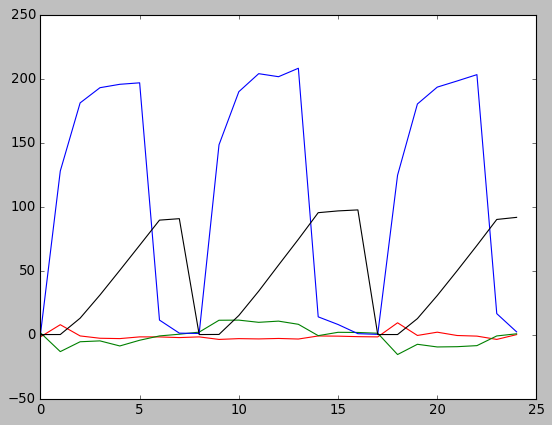

bye


In [10]:
"""
plotGY521.py
Events include the angle 
msg(g521,event, gyroSender, none, g521(TYPE,X,Y,Z,ANGLE),MSGNUM)
"""
import time
import paho.mqtt.client as paho
import matplotlib.pyplot as plt

brokerAddr="localhost"
duration = 30
x        = []
y        = []
z        = []
a        = []
goon     = True
msgnum   = 0

def on_message(client, userdata, message) :   #define callback
	global msgnum, x,y,z, goon
	if not goon :
		return
	#msg(androidSensor,event,android,none,androidSensor(TYPE,X,Y,Z),MSGNUM)
    #msg(g521,event, gyroSender, none, g521(TYPE,X,Y,Z,ANGLE),MSGNUM)
    #msg(rotationCmd,event,gyroSender,none,rotationCmd(CMD),MSGNUM)
	evMsg = str( message.payload.decode("utf-8")  )
	#print( evMsg )
	msgitems = evMsg.split(",")
	if msgitems[4].split('(')[1].split(')')[0] == "endofjob" :
		plt.plot(list(x), color='red')
		plt.plot(list(y), color='green')
		plt.plot(list(z), color='blue')
		plt.plot(list(a), color='black')
		plt.show()
		client.disconnect()
		return        
	x.append( float( msgitems[5] ) )
	y.append( float( msgitems[6] ) )
	vz = float( msgitems[7] )
	z.append( vz )
	angle = float( msgitems[8].split(')')[0] )
	a.append( angle )
	msgnum = msgnum + 1
	#print( "z=", vz, "angle=" , angle, "msgnum=", msgnum )

client= paho.Client("plotGY521")      
client.on_message=on_message            # Bind function to callback

client.connect(brokerAddr)              #connect
print("connected to broker ", brokerAddr)
print("subscribing to unibo/qak/events")
client.subscribe("unibo/qak/events")      #subscribe

print("collecting values; please wait ..." )
msgnum   = 0
client.loop_start()             #start loop to process received messages
time.sleep(duration)
client.disconnect()             #disconnect
print("bye")
client.loop_stop()              #stop loop        


### Experiment
<pre>

START JOB 2019-08-23 02:05:12.277301
z=0.038 angle=0.004 da=0.004
z=126.641 angle=12.668 da=12.664
z=180.252 angle=30.693 da=18.025
z=188.328 angle=49.526 da=18.833
z=187.511 angle=68.277 da=18.751
z=174.786 angle=85.756 da=17.479
z=0.405 angle=85.796 da=0.040
FIRST STEP DONE CMD=l ANGLE=85.796
COMPENSATE START CMD=l ANGLE=85.7961832061
COMPENSATE END CMD=l ANGLE=86.7786259542
z=0.046 angle=0.005 da=0.005
z=130.885 angle=13.093 da=13.089
z=179.618 angle=31.055 da=17.962
z=187.916 angle=49.847 da=18.792
z=191.382 angle=68.985 da=19.138
z=170.824 angle=86.067 da=17.082
z=3.908 angle=86.458 da=0.391
FIRST STEP DONE CMD=r ANGLE=86.458
COMPENSATE START CMD=r ANGLE=86.4580152672
COMPENSATE END CMD=r ANGLE=91.1595419847
</pre>